### Import Required Packages

In [1]:
import sys
sys.path.append('../.')

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from downstream.gap_fill.gf_dataloader import create_dataloader
from downstream.gap_fill.lightning_presetup import GAIAGapFill

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-04-25 13:20:34,206] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmpr6vshjte/test.c -o /tmp/tmpr6vshjte/test.o
INFO:root:x86_64-linux-gnu-gcc /tmp/tmpr6vshjte/test.o -laio -o /tmp/tmpr6vshjte/a.out
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmp6obl3v8t/test.c -o /tmp/tmp6obl3v8t/test.o
INFO:root:x86_64-linux-gnu-gcc /tmp/tmp6obl3v8t/test.o -L/usr/local/cuda -L/usr/local/cuda/lib64 -lcufile -o /tmp/tmp6obl3v8t/a.out
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmpkrdiql1w/test.c -o /tmp/tmpkrd

# Load model from checkpoint

In [2]:
config_path = "../configs/gap_fill_config.yaml"

# Create model using config file
model = GAIAGapFill(
    config_path=config_path,
)
    
model.configure_model()

checkpoint_dir = "../checkpoints/gaia-gapfill-v1.pt"
state_dict = torch.load(checkpoint_dir)
model.load_state_dict(state_dict)

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
INFO:downstream.gap_fill.lightning_wrapper:Mask Ratio: 0.1


<All keys matched successfully>

### Run Inference

In [4]:
def run_inference(model, num_samples, device='cuda', dtype=torch.float32, mask_ratio=0.5, 
                  data_path="../data/IR/*/*.nc4", **dataloader_kwargs):
    """
    Run inference and plot ground truth, masked input, and reconstruction.

    Args:
        model: PyTorch model with .model.encoder and .model.decoder.
        num_samples: Number of samples to visualize.
        device: Device to use ('cuda' or 'cpu').
        dtype: Data type to cast inputs.
        mask_ratio: Ratio of input to mask.
        data_path: Full path to the data files (including wildcards).
        **dataloader_kwargs: Additional keyword arguments for create_dataloader.
    """
    model.eval()
    model.to(device)
    
    loader = create_dataloader(
        data_path=data_path, 
        **dataloader_kwargs
    )
    samples_collected = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Running Inference", unit="sample"):
            x = batch['x'][:, :1, :1].to(device=device, dtype=dtype)
            x_mask = batch['x_mask'][:, :1, :1].to(device=device, dtype=dtype)
            _temporal_pos = [t.to(device) for t in batch['temporal_pos']] if 'temporal_pos' in batch else None
            temporal_pos = None  # do not include temporal encodings at inference time
            
            latent, mask, ids_restore, _ = model.model.encoder(
                x, x_mask, mask_ratio=mask_ratio, temporal_pos=temporal_pos
            )
            pred = model.model.decoder(latent, ids_restore, temporal_pos=temporal_pos)
            pred_unpatched = model.model.encoder.unpatchify(pred)
            
            s, p, q = model.model.encoder.patch_embed.patch_size
            mask = model.model.encoder.unpatchify(mask.unsqueeze(-1).repeat(1, 1, s * p * q))
            
            for i in range(min(x.size(0), num_samples - samples_collected)):
                plot_reconstructions(
                    ground_truth=x[i],
                    masked_input=x[i] * (1 - mask[i]),
                    reconstruction=pred_unpatched[i]
                )
                samples_collected += 1
                if samples_collected >= num_samples:
                    return


def plot_reconstructions(ground_truth, masked_input, reconstruction):
    """
    Display ground truth, masked input, and reconstruction
    as global maps with borders and coastlines, flipped vertically.
    """
    projection = ccrs.PlateCarree()
    borders = cfeature.BORDERS

    fig = plt.figure(figsize=(15, 5))
    images = [ground_truth, masked_input, reconstruction]
    titles = ["Ground Truth", "Masked Input", "Reconstruction"]

    for idx, (img, title) in enumerate(zip(images, titles), start=1):
        ax = fig.add_subplot(1, 3, idx, projection=projection)
        ax.set_extent([-180, 180, -60, 60], crs=projection)

        # get the numpy array and flip it vertically
        arr = img.squeeze().cpu().numpy()
        arr = np.flipud(arr)   

        im = ax.imshow(
            arr,
            transform=projection,
            extent=[-180, 180, -60, 60],
            cmap='RdBu_r',
            vmin=0,
            vmax=1
        )
        ax.add_feature(borders, linewidth=0.5, edgecolor='black')
        ax.coastlines(resolution='50m', linewidth=0.5)
        ax.set_title(title)
        ax.axis('off')

    # shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Normalized value')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

Running Inference:   0%|                                                                         | 0/6 [00:00<?, ?sample/s]INFO:downstream.gap_fill.models:missing_data_ratio: tensor([0.0716], device='cuda:0')
INFO:downstream.gap_fill.models:adjusted_mask_ratio: 0.0716145858168602
/tmp/ipykernel_2067/2337928963.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


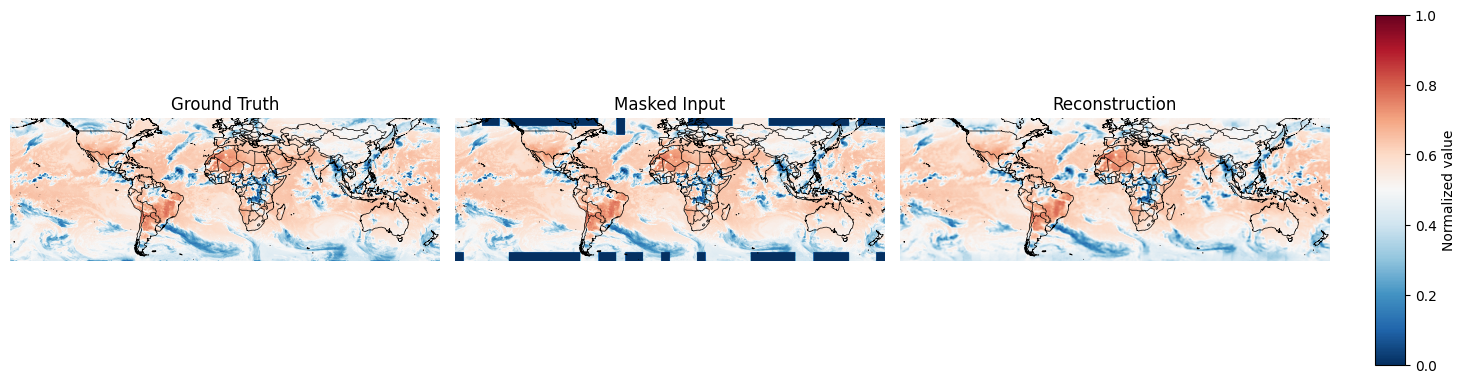

Running Inference:   0%|                                                                         | 0/6 [00:07<?, ?sample/s]


In [6]:
# Example call using the cleaned-up dataloader and inference functions
run_inference(
    model=model,
    num_samples=1,
    device='cuda',
    dtype=torch.float32,
    mask_ratio=0,
    data_path="../data/IR/*/*.nc4",
    max_files=20,
)